In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
from sklearn import svm
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import cv2
from skimage.feature import hog
from skimage import data, exposure
from skimage.color import rgb2gray
from keras.datasets import cifar10
import tensorflow as t

## Sobel

In [2]:
img = cv2.imread('doberman.jpg')

In [3]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [4]:
# Використання фільтра Собеля для визначення границь
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)
sobel = np.sqrt(sobelx**2 + sobely**2)

In [5]:
# Визначення кутів границь
theta = np.arctan2(sobely, sobelx)
theta = np.rad2deg(theta)

In [6]:
cv2.imshow('Original', img)
cv2.imshow('Sobel', sobel.astype(np.uint8))

cv2.waitKey(0)
cv2.destroyAllWindows()

## HOG

In [7]:
# витягнення ознак з зображення
fd, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, channel_axis=-1)

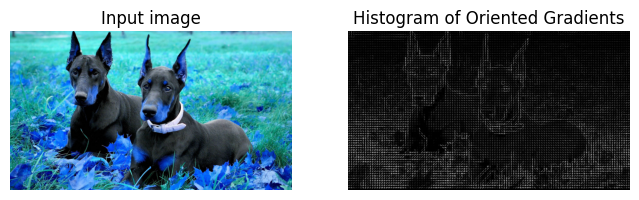

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(img, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

## CIFAR-10, HOG

In [9]:
# Завантаження датасету CIFAR-10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

D:\python_projects\python_3_10_9\venv\lib\site-packages\matplotlib\text.py:1241: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


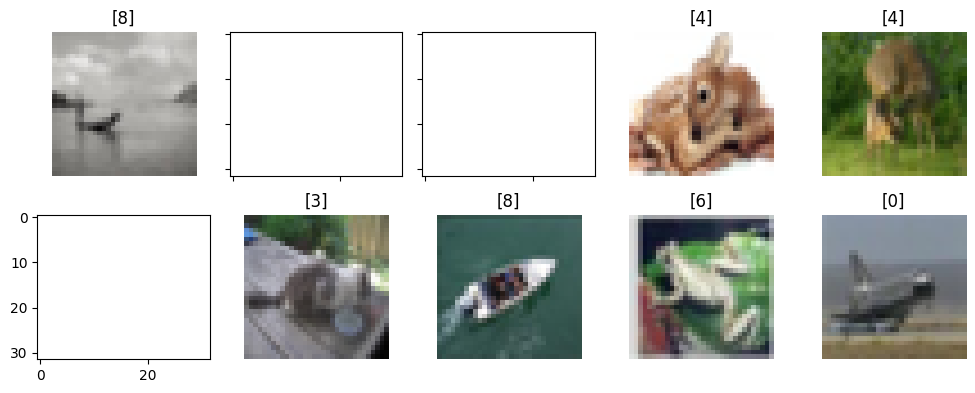

In [10]:
# Вибір випадкових зображень для відображення
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4),
                         sharex=True, sharey=True)
ax = axes.ravel()
for i in np.random.choice(X_train.shape[0], 10):
    image = X_train[i]
    ax[i%10].imshow(image)
    ax[i%10].set_title(y_train[i])
    ax[i%10].axis('off')
plt.tight_layout()
plt.show()

In [11]:
# Витягнення ознак зображень з використанням HOG
X_train_hog = []
for i in range(X_train.shape[0]):
    fd, hog_image = hog(X_train[i], orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(1, 1), visualize=True, channel_axis=-1)
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    X_train_hog.append(fd)

X_test_hog = []
for i in range(X_test.shape[0]):
    fd, hog_image = hog(X_test[i], orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(1, 1), visualize=True, channel_axis=-1)
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    X_test_hog.append(fd)

In [12]:
# Підготовка даних для класифікації
X_train_hog = np.array(X_train_hog)
X_test_hog = np.array(X_test_hog)
y_train = y_train.ravel()
y_test = y_test.ravel()

In [13]:
# Розбиття даних на тренувальний та тестовий набори
X_train_hog, X_val_hog, y_train, y_val = train_test_split(X_train_hog, y_train, test_size=0.2, random_state=42)

In [14]:
# Класифікація з використанням SVM
clf = LinearSVC(random_state=42)
clf.fit(X_train_hog, y_train)
y_pred = clf.predict(X_val_hog)

In [15]:
# Оцінка результатів класифікації
acc = accuracy_score(y_val, y_pred)
prec = precision_score(y_val, y_pred, average='macro')
rec = recall_score(y_val, y_pred, average='macro')
f1 = f1_score(y_val, y_pred, average='macro')

print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1-Score:", f1)

Accuracy: 0.4304
Precision: 0.42411026331593915
Recall: 0.4313097863395258
F1-Score: 0.41965561042882893


## SIFT

In [16]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

sift = cv2.SIFT_create()  # Викроситання SIFT
descriptors = []

# Отримання дескрипторів для всіх зображень у наборі даних
for i in np.arange(x_train.shape[0]):
    _, imgDesc = sift.detectAndCompute(x_train[i], None)
    if imgDesc is not None:
        for j in np.arange(imgDesc.shape[0]):
            descriptors.append(imgDesc[j])

descriptors = np.array(descriptors)

kmeans = KMeans(n_clusters=10).fit(descriptors)

train_hist_X = []
train_hist_Y = []

for i in np.arange(x_train.shape[0]):
    _, imgDesc = sift.detectAndCompute(x_train[i], None)
    if imgDesc is not None:
        kcent = kmeans.predict(imgDesc)
        hist, _ = np.histogram(kcent, bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], density=True)
        train_hist_X.append(hist)
        train_hist_Y.append(y_train[i])

train_hist_X = np.array(train_hist_X).reshape((-1, 10))
train_hist_Y = np.array(train_hist_Y).reshape((-1,))

# Train SVM

modSVM = SVC()
modSVM.fit(train_hist_X, train_hist_Y.reshape((-1,)))

conf_matrix_test = np.zeros((10, 10))

preds = []
labels = []
for i in np.arange(x_test.shape[0]):
    _, imgDesc = sift.detectAndCompute(x_test[i], None)
    if imgDesc is not None:
        kcent = kmeans.predict(imgDesc)
        hist, _ = np.histogram(kcent, bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], density=True)
        ret = modSVM.predict(hist.reshape((1, -1)))[0]
        preds.append(ret)
        labels.append(y_test[i, 0])
        real = y_test[i, 0]
        conf_matrix_test[real, ret] = conf_matrix_test[real, ret] + 1

print("accuracy is {0}".format(accuracy_score(labels, preds)))

D:\python_projects\python_3_10_9\venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


accuracy is 0.2185244587008821


### HOG дає кращі результати